In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

from src.VAE import LinearVAE

In [2]:
encoder1 = nn.Sequential(nn.Linear(28 * 28, 256),
                         nn.ReLU(),
                         nn.Linear(256, 128),
                         nn.ReLU())
decoder1 = nn.Sequential(nn.Linear(64, 128),
                         nn.ReLU(),
                         nn.Linear(128, 256),
                         nn.ReLU(),
                         nn.Linear(256, 28 * 28),
                         nn.Sigmoid())
encoderDeep = nn.Sequential(nn.Linear(28 * 28, 256),
                            nn.ReLU(),
                            nn.Linear(256, 128),
                            nn.ReLU(),
                            nn.Linear(128, 64),
                            nn.ReLU())
decoderDeep = nn.Sequential(nn.Linear(16, 64),
                            nn.ReLU(),
                            nn.Linear(64, 128),
                            nn.ReLU(),
                            nn.Linear(128, 256),
                            nn.ReLU(),
                            nn.Linear(256, 28 * 28),
                            nn.Sigmoid())
encoderShallow = nn.Sequential(nn.Linear(28 * 28, 128),
                               nn.ReLU())
decoderShallow = nn.Sequential(nn.Linear(2, 128),
                               nn.ReLU(),
                               nn.Linear(128, 28 * 28),
                               nn.Sigmoid())
vae = LinearVAE(encoder1, decoder1, 128, 64)

In [3]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)

## KLD and BCE

In [8]:
model = vae.to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [9]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    allReconLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output, mu, log_var = model(data)
            reconLoss = BCE(output, data)
            loss = KLD(mu, log_var) + reconLoss
            loss.backward()
            optimizer.step()
            # allLoss.append(loss.item())
            allReconLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTotal Loss: {:.6f}\tReconstruction Loss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), reconLoss.item(), optimizer.param_groups[0]['lr']))
    return allLoss, allReconLoss

In [10]:
for epoch in range(1, 201):
    _, loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

 88%|████████▊ | 52/59 [00:04<00:00, 12.44batch/s,  Epoch: 117 	Total Loss: 0.241821	Reconstruction Loss: 0.206395	 lr: 0.00000010]


KeyboardInterrupt: 

In [11]:
torch.save(model.state_dict(),'vanilla vae')

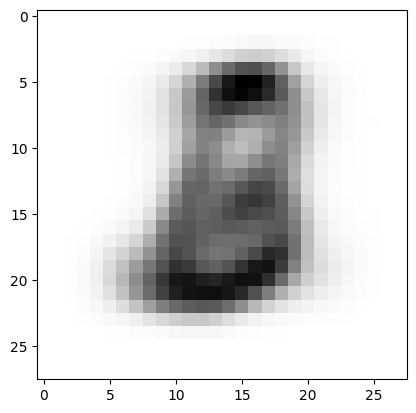

In [31]:
z = torch.normal(0, 1, size=(1, 64)).cuda()
plt.imshow(model.sample(z).cpu().detach().view(28, 28), cmap='Greys')

In [32]:
img0 = next(iter(train_loader))[0][0]

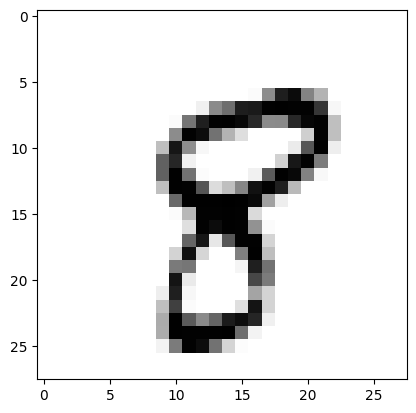

In [33]:
plt.imshow(img0[0], cmap='Greys')

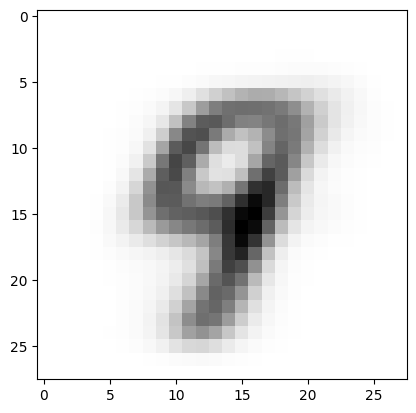

In [39]:
_, output, _ = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(model.sample(output).cpu().detach().view(28, 28), cmap='Greys')

## Only BCE

In [7]:
model = LinearVAE(encoder1, decoder1, 128, 64).cuda()
optimizer = optim.Adadelta(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [8]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    allReconLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output, mu, log_var = model(data)
            reconLoss = BCE(output, data)
            loss = reconLoss
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            allReconLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTotal Loss: {:.6f}\tReconstruction Loss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), reconLoss.item(), optimizer.param_groups[0]['lr']))
    return allLoss, allReconLoss

In [9]:
for epoch in range(1, 201):
    _, loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

100%|██████████| 59/59 [00:05<00:00, 11.62batch/s,  Epoch: 200 	Total Loss: 0.086052	Reconstruction Loss: 0.086052	 lr: 10.00000000]


In [10]:
for epoch in range(201, 301):
    _, loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

100%|██████████| 59/59 [00:05<00:00, 11.52batch/s,  Epoch: 300 	Total Loss: 0.079921	Reconstruction Loss: 0.079921	 lr: 0.00000001]


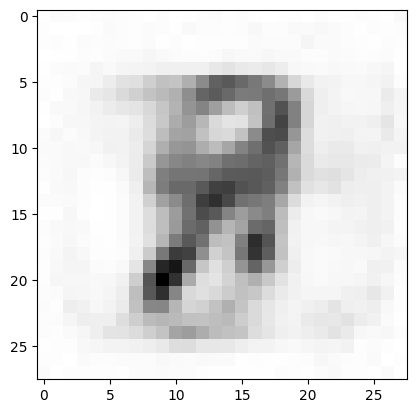

In [11]:
z = torch.normal(0, 1, size=(1, 64)).cuda()
plt.imshow(model.sample(z).cpu().detach().view(28, 28), cmap='Greys')

In [41]:
img0 = next(iter(train_loader))[0][100]

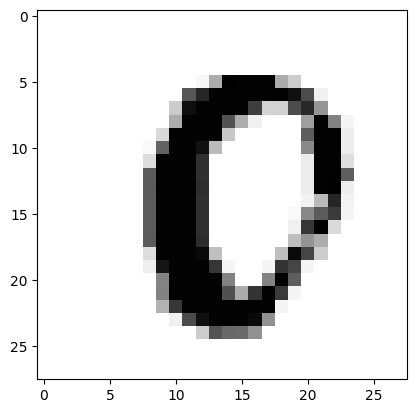

In [42]:
plt.imshow(img0[0], cmap='Greys')

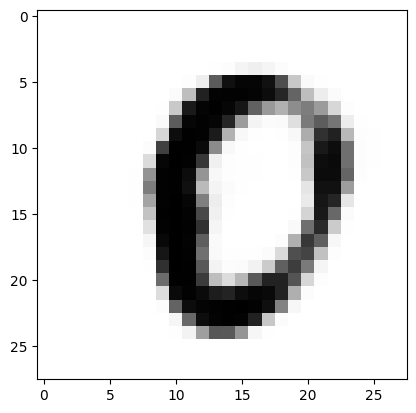

In [43]:
output, mu, log_var = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(output.cpu().detach().view(28, 28), cmap='Greys')

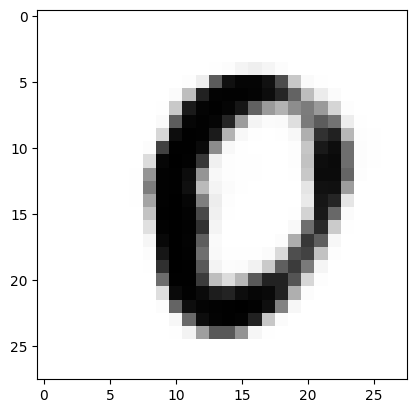

In [44]:
output, mu, log_var = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(model.sample(mu).cpu().detach().view(28, 28), cmap='Greys')

In [45]:
log_var

tensor([[-10.5637, -10.1094,  -7.7750, -10.1609, -10.0076, -10.4946,  -9.2917,
          -9.8507,  -9.6657,  -8.1323,  -8.8957,  -9.7380,  -9.7429,  -9.7118,
          -9.2514, -10.0264,  -9.2122,  -8.6569,  -8.3118,  -8.8429,  -9.1026,
          -9.6348,  -9.4555,  -9.9072, -10.2568, -10.7149,  -8.0288, -10.7044,
          -9.9455,  -9.2772,  -9.2657,  -8.9200,  -7.5717,  -7.4330,  -9.0137,
          -9.5351,  -8.7984,  -8.9146,  -9.8621, -10.0577,  -9.6304,  -8.4304,
          -9.1021,  -8.7139, -10.8877,  -8.3546,  -9.3110,  -9.0772,  -9.9627,
         -10.0111,  -9.7918,  -9.9560,  -9.5776,  -7.6361,  -8.5823,  -8.0218,
          -8.4124,  -8.0648,  -9.8029,  -9.9599,  -9.8197, -10.5758,  -9.0136,
          -9.5177]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
mu

tensor([[-1.8884,  0.9862,  2.0818,  1.2970,  0.5249, -7.3176, -0.1697, -3.6089,
         -7.1460, -1.1976, -2.1610,  2.7611, -2.6682, -6.6079,  0.3251,  0.9082,
          4.7267,  0.6392, -3.6590, -0.3039, -2.7431,  2.8382, -8.0505,  0.1568,
         -0.4915, -3.3009,  0.8933, -0.3955, -1.5419,  0.9992, -4.1948,  2.2241,
          2.0364,  2.7650,  7.3925,  5.6287, -6.6996,  0.9697, -3.2818,  1.6239,
         -5.5586, -1.3665,  3.5330, 10.1366, -7.8894, -1.8327,  2.7057,  3.0717,
          5.9085,  8.3451,  3.0054,  2.5626, -2.5202,  2.5721,  3.1154, -5.3000,
          1.1844, -6.2718,  1.0749, -0.1669,  1.0059,  6.4541, -1.4058, -3.2136]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [31]:
mms=MinMaxScaler()
mms01=mms.fit_transform(mu.detach().cpu().numpy().T)

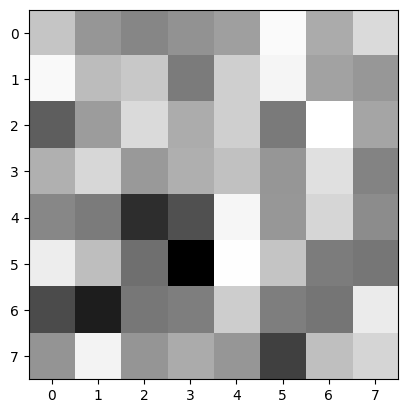

In [34]:
plt.imshow(mms01.reshape(8,8), cmap='Greys')

In [20]:
testBatch0 = next(iter(train_loader))[0]

In [21]:
_, testMu, testLogvar = model(testBatch0.view(-1, 28 * 28).cuda())

In [22]:
testMu

tensor([[-0.5128,  1.3165,  5.4113,  ...,  3.1938,  0.7622, 11.3499],
        [ 5.8709, -8.0070, -1.8068,  ...,  3.3748, -5.8233, -2.8467],
        [-0.7510,  3.7900, -3.5206,  ..., -9.5367, -2.3499,  4.8116],
        ...,
        [-1.9266,  0.3360, -3.7726,  ...,  5.2527,  2.3007,  3.1730],
        [ 3.0311,  2.0077, -0.3622,  ...,  2.1320, -2.6032,  0.1624],
        [-6.9123, -3.1775, -3.5171,  ...,  3.0247, -1.1947,  2.1324]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [23]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(10)

In [24]:
gm.fit(testMu.detach().cpu())

GaussianMixture(n_components=10)

In [25]:
gm.means_

array([[ 2.09455663e+00, -1.47139077e+00, -1.23500425e+00,
        -7.28138155e-01,  3.62909069e+00,  3.24443742e+00,
         3.34237152e+00,  5.11340520e-01, -7.03782764e+00,
        -3.31453798e+00, -7.29096960e+00,  5.64887209e-01,
         4.40147489e+00, -5.81845108e+00,  1.09150710e+00,
        -3.24027120e+00,  6.74270108e+00, -2.05052932e+00,
         3.31741901e+00,  4.06436206e+00,  5.18497719e-01,
         4.80043939e-01, -2.25167670e+00, -1.99298499e+00,
        -1.37351113e+00, -2.44194610e+00, -3.06080601e+00,
         8.12018612e-01,  1.48617579e+00, -1.93147975e+00,
         4.83091164e+00,  4.64097398e+00, -1.16134437e-02,
        -3.20307553e+00,  2.75267384e+00,  1.61145734e+00,
        -4.94600104e+00, -3.02253473e+00, -1.61490887e-02,
         5.58910071e+00,  5.30883651e+00, -1.77360713e-01,
        -6.71743467e+00, -5.74014124e+00,  1.61652159e+00,
        -5.94784844e+00,  2.27293650e+00, -2.66988408e+00,
        -3.51815625e-01, -2.18645586e+00,  1.60708577e+0

In [28]:
gm.covariances_[0]

array([[ 22.74618572,  -9.93144553, -14.89002921, ...,   3.81566241,
         -2.91658724,  -0.3809777 ],
       [ -9.93144553,  10.67328019,   3.21255551, ...,   1.9031549 ,
         -0.21373915,  -1.40233493],
       [-14.89002921,   3.21255551,  37.94407034, ..., -10.51175702,
         -4.76790207,   1.71498224],
       ...,
       [  3.81566241,   1.9031549 , -10.51175702, ...,  10.94361122,
          0.65014497,  -2.60406716],
       [ -2.91658724,  -0.21373915,  -4.76790207, ...,   0.65014497,
          9.40825212,   0.6906487 ],
       [ -0.3809777 ,  -1.40233493,   1.71498224, ...,  -2.60406716,
          0.6906487 ,   6.7382372 ]])

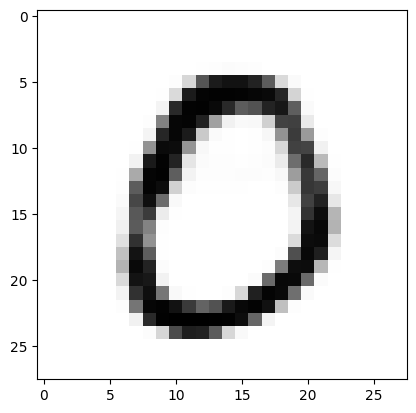

In [86]:
gmMeanOutput = model.sample(
    torch.tensor(np.random.multivariate_normal(gm.means_[0], gm.covariances_[0]), dtype=torch.float32).cuda())
plt.imshow(gmMeanOutput.cpu().detach().view(28, 28), cmap='Greys')

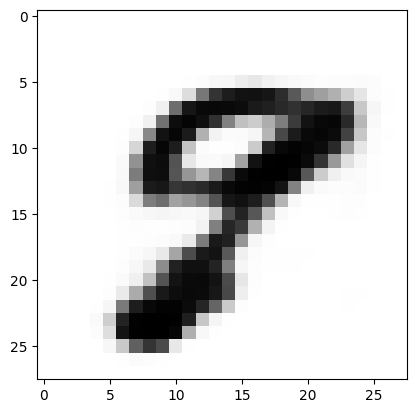

In [159]:
gmMeanOutput = model.sample(
    torch.tensor(np.random.multivariate_normal(gm.means_[8], gm.covariances_[8]), dtype=torch.float32).cuda())
plt.imshow(gmMeanOutput.cpu().detach().view(28, 28), cmap='Greys')

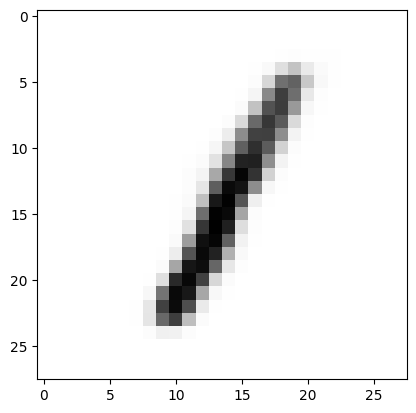

In [139]:
gmMeanOutput = model.sample(torch.tensor(gm.means_[8], dtype=torch.float32).cuda())
plt.imshow(gmMeanOutput.cpu().detach().view(28, 28), cmap='Greys')

## KLD and L1

In [6]:
model = LinearVAE(encoder1, decoder1, 128, 64).cuda()
optimizer = optim.Adadelta(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [7]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    allReconLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output, mu, log_var = model(data)
            reconLoss = L1Loss(output, data)
            loss = reconLoss + KLD(mu, log_var)
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            allReconLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTotal Loss: {:.6f}\tReconstruction Loss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), reconLoss.item(), optimizer.param_groups[0]['lr']))
    return allLoss, allReconLoss

In [8]:
for epoch in range(1, 201):
    _, loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

 81%|████████▏ | 48/59 [00:03<00:00, 13.48batch/s,  Epoch: 35 	Total Loss: 0.125190	Reconstruction Loss: 0.125186	 lr: 0.00100000]


KeyboardInterrupt: 

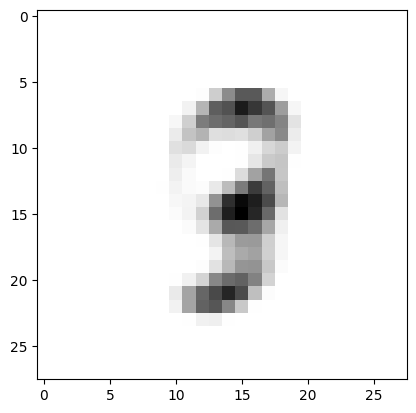

In [9]:
z = torch.normal(0, 1, size=(1, 64)).cuda()
plt.imshow(model.sample(z).cpu().detach().view(28, 28), cmap='Greys')

In [10]:
img0 = next(iter(train_loader))[0][0]

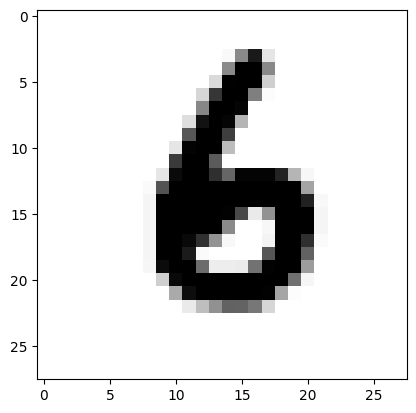

In [11]:
plt.imshow(img0[0], cmap='Greys')

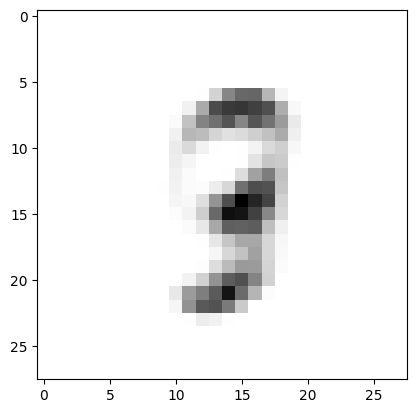

In [12]:
output, _, _ = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(output.cpu().detach().view(28, 28), cmap='Greys')